# CARTO Data Observatory - Data Enrichment

This notebook shows how to use CARTOframes to enrich a dataframe with data from CARTO's Data Observatory. Please, visit [CARTOframes Guides](https://carto.com/developers/cartoframes/guides/) to learn more about the enrichment functionality.

We will show CARTOframes enrichment functionality with an example in which we will quantify the number of eating places within a 5-minute isochrone for all sports POI's in Madrid downtown.

The notebook is organized as follows:
1. [Download sports POIs](#section1)
2. [Calculate isochrones](#section2)
3. [Enrich isochrones](#section3)
 - [Simple enrichment: Counting the number of POI's within isochrones](#section31)
 - [Enrichment applying filters: Counting the number of eating places](#section32)
 - [Brief analysis](#section33)

**Note** for this notebook we are using the premium [dataset of Pitney Bowes POI's in Spain](https://carto.com/spatial-data-catalog/browser/dataset/pb_points_of_i_94bda91b/).

## Setup

### Import packages

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from cartoframes.auth import set_default_credentials
from cartoframes.data.observatory import *
from cartoframes.data.services import Isolines
from cartoframes.viz import *

sns.set_style('whitegrid')
%matplotlib inline

### Set CARTO default credentials

In order to be able to use the Data Observatory via CARTOframes, you need to set your CARTO account credentials first.

Please, visit the [Authentication guide](https://carto.com/developers/cartoframes/guides/Authentication/) for further detail.

In [2]:
username = 'XXXXXXXXXX'
api_key  = 'XXXXXXXXXX'    # Master API key. Do not make this file public!

set_default_credentials(username=username, api_key=api_key)

**Note about credentials**

For security reasons, we recommend storing your credentials in an external file to prevent publishing them by accident when sharing your notebooks. You can get more information in the section _Setting your credentials_ of the [Authentication guide](https://carto.com/developers/cartoframes/guides/Authentication/).

<a id='section1'></a>
## 1. Download sports POIs

We need to start with the initial DataFrame that we would like to enrich. Normally, this initial DataFrame contains your own data that you later enrich with data from the Data Observatory. In this case, we will download all sports POI's and use it as our initial DataFrame.

We first check that we are subscribed to PB POIs dataset in Spain and download the sports POI's within a bounding box covering Madrid downtown. You can calculate your bounding box of interest using [bboxfinder](http://bboxfinder.com).

For a step by step description on how to discover and download premium datasets, take a look at templates (**LINKS**).

In [3]:
Catalog().subscriptions().datasets.to_dataframe()

,slug,name,description,category_id,country_id,data_source_id,provider_id,geography_name,geography_description,temporal_aggregation,time_coverage,update_frequency,is_public_data,lang,version,category_name,provider_name,geography_id,id
0,ags_sociodemogr_f510a947,Sociodemographics - United States of America (...,Census and ACS sociodemographic data estimated...,demographics,usa,sociodemographics,ags,Census Block Group - United States of America ...,Shoreline clipped TIGER/Line boundaries. More ...,yearly,"[2019-01-01, 2020-01-01)",yearly,False,eng,2019,Demographics,Applied Geographic Solutions,carto-do-public-data.carto.geography_usa_block...,carto-do.ags.demographics_sociodemographics_us...
1,pb_points_of_i_94bda91b,Points Of Interest - Spain (Latitude/Longitude),Point of interest database per categories,points_of_interest,esp,points_of_interest,pitney_bowes,Latitude/Longitude - Spain,Location of Points of Interest,monthly,None,monthly,False,eng,v1,Points of Interest,Pitney Bowes,carto-do.pitney_bowes.geography_esp_latlon_v1,carto-do.pitney_bowes.pointsofinterest_pointso...
2,sg_social_dist_667d8e8e,Social Distancing Metrics - United States of A...,"Due to the COVID-19 pandemic, people are curre...",covid19,usa,social_distancing,safegraph,Census Block Group - United States of America ...,Shoreline clipped TIGER/Line boundaries. More ...,daily,None,daily,False,eng,v1,Covid-19,SafeGraph,carto-do-public-data.carto.geography_usa_block...,carto-do.safegraph.covid19_socialdistancing_us...
3,mbi_consumer_pr_c4d89dd7,Consumer Profiles - Japan (Cho-Cho-Moku),The MB International Consumer Styles describe ...,demographics,jpn,consumer_profiles,mbi,Cho-Cho-Moku - Japan,MBI Digital Boundaries for Japan at Cho-Cho-Mo...,yearly,"[2019-01-01, 2020-01-01)",yearly,False,eng,2020,Demographics,Michael Bauer International,carto-do.mbi.geography_jpn_chochomoku_2020,carto-do.mbi.demographics_consumerprofiles_jpn...
4,u360_sociodemogr_28e93b81,Sociodemographics - Spain (Grid 100m),Curation of socio-demographic and socio-econom...,demographics,esp,sociodemographics,unica360,Grid 100m,100x100m grid,yearly,None,yearly,False,eng,2019,Demographics,Unica360,carto-do.unica360.geography_esp_grid100x100m_2019,carto-do.unica360.demographics_sociodemographi...
5,ags_consumer_sp_dbabddfb,Consumer Spending - United States of America (...,The Consumer Expenditure database consists of ...,demographics,usa,consumer_spending,ags,Census Block Group - United States of America,None,yearly,None,yearly,False,eng,2020,Demographics,Applied Geographic Solutions,carto-do.ags.geography_usa_blockgroup_2015,carto-do.ags.demographics_consumerspending_usa...
6,pb_consumer_po_62cddc04,Points Of Interest - Consumer - United States ...,Consumer Point of interest database per catego...,points_of_interest,usa,consumer_points_of_interest,pitney_bowes,Latitude/Longitude - United States of America,Location of Points of Interest,monthly,None,monthly,False,eng,v1,Points of Interest,Pitney Bowes,carto-do.pitney_bowes.geography_usa_latlon_v1,carto-do.pitney_bowes.pointsofinterest_consume...
7,mc_geographic__7980c5c3,Geographic Insights - United States of America...,"Geographic Insights validate, evaluate and ben...",financial,usa,geographic_insights,mastercard,Census Block Group - United States of America ...,Shoreline clipped TIGER/Line boundaries. More ...,monthly,"[2019-01-01, 2020-01-01)",monthly,False,eng,v1,Financial,Mastercard,carto-do-public-data.carto.geography_usa_block...,carto-do.mastercard.financial_geographicinsigh...
8,spa_geosocial_s_d5dc42ae,Geosocial Segments - United States of America ...,"By analysing feeds from Twitter, Instagram, Me...",behavioral,usa,geosocial_segments,spatial_ai,Census Block Group - United States of America ...,Shoreline clipped TIGER/Line boundaries. More ...,quarterly,"[2020-01-01, 2020-04-01)",quarterly,False,eng,v1,Behavioral,Spatial.ai,carto-do-public-data.carto.geography_usa_block...,carto-do.spatial_ai.behavioral_geosocialsegmen...
9,mc_consumer_j

In [4]:
pois_ds = Dataset.get('pb_points_of_i_94bda91b')

In [5]:
pois_ds.head()

,HTTP,ISO3,NAME,SIC1,SIC2,SIC8,CLASS,EMAIL,GROUP,PB_ID,...,GLOBAL_ULTIMATE_AREANAME1,GLOBAL_ULTIMATE_AREANAME3,GLOBAL_ULTIMATE_INDICATOR,DOMESTIC_ULTIMATE_POSTCODE,DOMESTIC_ULTIMATE_AREANAME1,DOMESTIC_ULTIMATE_AREANAME3,GLOBAL_ULTIMATE_BUSINESS_NAME,GLOBAL_ULTIMATE_STREET_ADDRESS,DOMESTIC_ULTIMATE_BUSINESS_NAME,DOMESTIC_ULTIMATE_STREET_ADDRESS
0,None,ESP,EL BOLEO,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1171969022,...,None,None,None,None,None,None,None,None,None,None
1,None,ESP,PICO ANAYET,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1198815451,...,None,None,None,None,None,None,None,None,None,None
2,None,ESP,CABAÑAS,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1172381728,...,None,None,None,None,None,None,None,None,None,None
3,None,ESP,PIC DE CASAMANYA,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1394044479,...,None,None,None,None,None,None,None,None,None,None
4,None,ESP,HOYO POLLALES,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1170858166,...,None,SANTIAGO DE COMPOSTELA,None,None,None,None,None,None,None,None
5,None,ESP,PICO TESORERO,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1394844928,...,None,None,None,None,None,None,None,None,None,None
6,None,ESP,PICA D'ESTATS,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1512254206,...,None,None,None,None,None,None,None,None,None,None
7,None,ESP,PEÑARROYA,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1510135375,...,None,None,None,None,None,None,None,None,None,None
8,None,ESP,PUERTO DE PIEDRASLUENGAS,0119,None,None,FRUIT AND VEGETABLE MARKETS,None,AGRICULTURAL PRODUCTION - CROPS,1510749875,...,None,None,None,None,None,None,None,None,None,None
9,None,ESP,PICO DE LA CRUZ,0119,None,None,FRUIT AND VEGETABLE MARKETS,ORDERS@LEWISSTAGNETTO.COM,AGRICULTURAL PRODUCTION - CROPS,1507940952,...,None,None,None,None,None,None,None,None,None,None


In [6]:
sql_query = """
  SELECT * except(do_label) FROM $dataset$ 
  WHERE TRADE_DIVISION = 'DIVISION M. - SPORTS' 
  AND ST_IntersectsBox(geom, -3.716398,40.407437,-3.690477,40.425277)
"""

pois_df = pois_ds.to_dataframe(sql_query=sql_query)

# To keep only the latest version of POI's
pois_df = pois_df.sort_values(['NAME', 'do_date']).groupby('NAME').first().reset_index()

pois_df.head()

,NAME,geoid,do_date,BRANDNAME,PB_ID,TRADE_NAME,FRANCHISE_NAME,ISO3,AREANAME4,AREANAME3,...,GLOBAL_ULTIMATE_STREET_ADDRESS,GLOBAL_ULTIMATE_AREANAME3,GLOBAL_ULTIMATE_AREANAME1,GLOBAL_ULTIMATE_COUNTRY,GLOBAL_ULTIMATE_POSTCODE,FAMILY_MEMBERS,HIERARCHY_CODE,TICKER_SYMBOL,EXCHANGE_NAME,geom
0,ACQUAPLAYA SPA,2204263540#-3.7095628#40.4226394,2020-04-01,NaN,2204263540,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7095628 40.4226394)
1,ALAMBIQUE TIENDA Y ESCUELA DE COCINA,2157202351#-3.7109121#40.4198204,2019-12-01,NaN,2157202351,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7109121 40.4198204)
2,ALCÁZAR NIGHT,2137823204#-3.69905#40.4178,2019-12-01,NaN,2137823204,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.69905 40.4178)
3,ALICIA PRODUCE,2181768913#-3.7112#40.42404,2020-02-01,NaN,2181768913,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7112 40.42404)
4,ALMA PILATES,2197072938#-3.7033635#40.4141477,2020-04-01,NaN,2197072938,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7033635 40.4141477)


<a id='section2'></a>
## 2. Calculate isochrones

For this analysis, we are interested in knowing the number of eating places reachable within 5 minutes for every sport POI. We'll now proceed to calculate 5-minute isochrones for every POI, which represent the area reachable within 5 minutes.

You can read more regarding isochrones on [CARTOframes Guides](https://carto.com/developers/cartoframes/guides/).

In [7]:
iso_service = Isolines()
isochrones_gdf, isochrones_metadata = iso_service.isochrones(pois_df, [300], mode='walk', geom_col='geom')

Success! Isolines created correctly


In [8]:
isochrones_gdf.head()

,source_id,data_range,the_geom
0,0,300,"MULTIPOLYGON (((-3.71192 40.42488, -3.71149 40..."
1,27,300,"MULTIPOLYGON (((-3.70505 40.41595, -3.70462 40..."
2,29,300,"MULTIPOLYGON (((-3.71123 40.42419, -3.71063 40..."
3,30,300,"MULTIPOLYGON (((-3.70179 40.42505, -3.70171 40..."
4,31,300,"MULTIPOLYGON (((-3.71055 40.42351, -3.70995 40..."


In [9]:
pois_df['isochrone'] = isochrones_gdf.sort_values('source_id')['the_geom'].values
pois_df.head()

,NAME,geoid,do_date,BRANDNAME,PB_ID,TRADE_NAME,FRANCHISE_NAME,ISO3,AREANAME4,AREANAME3,...,GLOBAL_ULTIMATE_AREANAME3,GLOBAL_ULTIMATE_AREANAME1,GLOBAL_ULTIMATE_COUNTRY,GLOBAL_ULTIMATE_POSTCODE,FAMILY_MEMBERS,HIERARCHY_CODE,TICKER_SYMBOL,EXCHANGE_NAME,geom,isochrone
0,ACQUAPLAYA SPA,2204263540#-3.7095628#40.4226394,2020-04-01,NaN,2204263540,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7095628 40.4226394),"MULTIPOLYGON (((-3.71192 40.42488, -3.71149 40..."
1,ALAMBIQUE TIENDA Y ESCUELA DE COCINA,2157202351#-3.7109121#40.4198204,2019-12-01,NaN,2157202351,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7109121 40.4198204),"MULTIPOLYGON (((-3.71346 40.42093, -3.71321 40..."
2,ALCÁZAR NIGHT,2137823204#-3.69905#40.4178,2019-12-01,NaN,2137823204,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.69905 40.4178),"MULTIPOLYGON (((-3.70248 40.41750, -3.70222 40..."
3,ALICIA PRODUCE,2181768913#-3.7112#40.42404,2020-02-01,NaN,2181768913,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7112 40.42404),"MULTIPOLYGON (((-3.71346 40.42437, -3.71338 40..."
4,ALMA PILATES,2197072938#-3.7033635#40.4141477,2020-04-01,NaN,2197072938,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7033635 40.4141477),"MULTIPOLYGON (((-3.70660 40.41544, -3.70634 40..."


### Visualize isochrones

In [10]:
Map([Layer(pois_df, geom_col='geom'),
     Layer(pois_df, geom_col='isochrone', style=basic_style(opacity=0.1))])

<a id='section3'></a>
## 3. Enrich isochrones

We will now proceed to enrich our DataFrame. 

For enriching datasets, we use the Enrichment class. Please, visit [CARTOframes Guides](https://carto.com/developers/cartoframes/guides/) to learn more.

In [11]:
enrichment = Enrichment()

<a id='section31'></a>
### 3.1 Simple enrichment: Counting the number of POI's within isochrones

We will start by simply counting the number of POI's within each isochrone. This will allow us to measure how busy the area around each sport POI is.

In order to do this, we will use the Enrichment function `enrich_polygons()` for which we can select any variable, because we are only interested in counting POIs. That is why we selected the variable `CLASS_517d6003` that we will use later. Remember you can access the dataset variables doing `pois_ds.variables.to_dataframe()`.

**Note** that we need to specify the name of the geometry column (`geom_col`) because we are working with a DataFrame instead of a GeoDataFrame.

In [12]:
# Here we can use any variable because we're only interested in counts
pois_df = enrichment.enrich_polygons(
    pois_df,
    variables=['CLASS_517d6003'],
    aggregation='COUNT',
    geom_col='isochrone'
)

# We rename the column name to give it a more descriptive name
pois_df.rename(columns={'CLASS_y':'n_pois'}, inplace=True)
pois_df.head()

,NAME,geoid,do_date,BRANDNAME,PB_ID,TRADE_NAME,FRANCHISE_NAME,ISO3,AREANAME4,AREANAME3,...,GLOBAL_ULTIMATE_AREANAME1,GLOBAL_ULTIMATE_COUNTRY,GLOBAL_ULTIMATE_POSTCODE,FAMILY_MEMBERS,HIERARCHY_CODE,TICKER_SYMBOL,EXCHANGE_NAME,geom,isochrone,n_pois
0,ACQUAPLAYA SPA,2204263540#-3.7095628#40.4226394,2020-04-01,NaN,2204263540,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7095628 40.4226394),"MULTIPOLYGON (((-3.71192 40.42488, -3.71149 40...",52305
1,ALAMBIQUE TIENDA Y ESCUELA DE COCINA,2157202351#-3.7109121#40.4198204,2019-12-01,NaN,2157202351,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7109121 40.4198204),"MULTIPOLYGON (((-3.71346 40.42093, -3.71321 40...",17298
2,ALCÁZAR NIGHT,2137823204#-3.69905#40.4178,2019-12-01,NaN,2137823204,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.69905 40.4178),"MULTIPOLYGON (((-3.70248 40.41750, -3.70222 40...",32508
3,ALICIA PRODUCE,2181768913#-3.7112#40.42404,2020-02-01,NaN,2181768913,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7112 40.42404),"MULTIPOLYGON (((-3.71346 40.42437, -3.71338 40...",39959
4,ALMA PILATES,2197072938#-3.7033635#40.4141477,2020-04-01,NaN,2197072938,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7033635 40.4141477),"MULTIPOLYGON (((-3.70660 40.41544, -3.70634 40...",50419


#### Visualize enrichment

In [13]:
Map(Layer(pois_df, geom_col='geom', 
          style=size_continuous_style('n_pois'),
          legends=size_continuous_legend('# POIs'),
          popup_hover=[popup_element('NAME', 'Name'), 
                        popup_element('n_pois', 'Number of POIs')]))

<a id='section32'></a>
### 3.2 Enrichment applying filters: Counting the number of eating places

Now, we are interested in getting the number of eating places within a 5-minute isochrone for every sport POI. This requires using a filter to indicate that only eating places should be counted. Filters are added in a dictionary-like format, where the key is the filtering variable and the value is the filtering value.

If you are interested in knowing how to identify the variable to use as filter, check out this [notebook](**LINK TO NOTEBOOK**) on how to access and download premium data.

In [14]:
pois_df = enrichment.enrich_polygons(
    pois_df,
    variables=['CLASS_517d6003'],
    aggregation='COUNT',
    geom_col='iso_10walk',
    filters={Variable.get('CLASS_517d6003').id:"= 'EATING PLACES/RESTAURANTS'"}
)

# We rename the column name to give it a more descriptive name
pois_df.rename(columns={'CLASS':'n_pois_eating'}, inplace=True)
pois_df.head()

,NAME,geoid,do_date,BRANDNAME,PB_ID,TRADE_NAME,FRANCHISE_NAME,ISO3,AREANAME4,AREANAME3,...,GLOBAL_ULTIMATE_COUNTRY,GLOBAL_ULTIMATE_POSTCODE,FAMILY_MEMBERS,HIERARCHY_CODE,TICKER_SYMBOL,EXCHANGE_NAME,geom,isochrone,n_pois,n_pois_eating
0,ACQUAPLAYA SPA,2204263540#-3.7095628#40.4226394,2020-04-01,NaN,2204263540,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7095628 40.4226394),"MULTIPOLYGON (((-3.71192 40.42488, -3.71149 40...",52305,3277
1,ALAMBIQUE TIENDA Y ESCUELA DE COCINA,2157202351#-3.7109121#40.4198204,2019-12-01,NaN,2157202351,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7109121 40.4198204),"MULTIPOLYGON (((-3.71346 40.42093, -3.71321 40...",17298,1718
2,ALCÁZAR NIGHT,2137823204#-3.69905#40.4178,2019-12-01,NaN,2137823204,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.69905 40.4178),"MULTIPOLYGON (((-3.70248 40.41750, -3.70222 40...",32508,2445
3,ALICIA PRODUCE,2181768913#-3.7112#40.42404,2020-02-01,NaN,2181768913,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7112 40.42404),"MULTIPOLYGON (((-3.71346 40.42437, -3.71338 40...",39959,3533
4,ALMA PILATES,2197072938#-3.7033635#40.4141477,2020-04-01,NaN,2197072938,NaN,NaN,ESP,NaN,MADRID,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT(-3.7033635 40.4141477),"MULTIPOLYGON (((-3.70660 40.41544, -3.70634 40...",50419,4474


#### Visualize enrichment

In [15]:
Map(Layer(pois_df, geom_col='geom', 
          style=size_continuous_style('n_pois_eating'), 
          legends=size_continuous_legend('# Eating POIs'),
          popup_hover=[popup_element('NAME', 'Name'), 
                        popup_element('n_pois_eating', 'Number of eating places')]))

<a id='section33'></a>
### 3.3 Brief analysis

Let's now take a look at how the total number of POI's and eating places around sport POI's correlate.

In [16]:
Layout([Map(Layer(pois_df, geom_col='geom', 
                  style=size_continuous_style('n_pois'),
                  legends=size_continuous_legend('# POIs'),
                  popup_hover=[popup_element('NAME', 'Name'), 
                               popup_element('n_pois', 'Number of POIs')])),
        Map(Layer(pois_df, geom_col='geom', 
                  style=size_continuous_style('n_pois_eating'), 
                  legends=size_continuous_legend('# Eating POIs'),
                  popup_hover=[popup_element('NAME', 'Name'), 
                               popup_element('n_pois_eating', 'Number of eating places')]))],
       map_height=550)

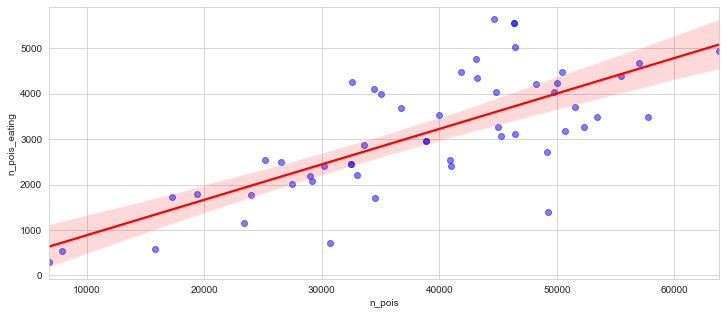

In [17]:
plt.figure(figsize=(12,5))
sns.regplot(pois_df['n_pois'], pois_df['n_pois_eating'], 
            scatter_kws={'color':'blue', 'alpha':0.5}, line_kws={'color':'red'})